## Data Cleaning and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import ast
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import prepr_functions
from prepr_functions import *

In [2]:
# Player's scraped
players_names = {'Rory McIlroy': '17419',
            'Tiger Woods': '10085', 
            'Jordan Spieth': '19976',
            'Justin Thomas': '20037',
            'Scottie Scheffler': '25786',
            'Collin Morikawa': '33992',
            'Sergio García': '10170',
            'Dustin Johnson': '17976',
            'Phil Mickelson': '10083',
            'Ian Poulter': '11956',
            'Talor Gooch': '27168',
            'Cameron Smith': '27755',
            'Joaquin Niemann': '33997',
            'Bryson DeChambeau': '29148',
            'Brooks Koepka': '25730',
            'Jon Rahm': '28177'}

In [3]:
#Load data
data = pd.read_csv('Press_Conferences.csv', index_col=0, converters={"answer": ast.literal_eval})

### Step 1 - Cleaning

#### Data Cleaning - Adapting data types and formats

In [4]:
#Transform questions using Regex to leave only text
data['question'] = data['question'].str.replace(r"[\['\],]", ' ', regex=True)
data['question'] = data['question'].apply(lambda x: re.sub(' +', ' ', str(x).strip())) #Removes the additional empty spaces between words
data['question'] = data['question'].apply(correct_quoted_contractions)

#Split answer to player / answers then Transform answers using Regex to leave only text
data['player'] = [i for i,n in data['answer']]
data['reply'] = [n for i,n in data['answer']]
data = data.drop(['answer'],axis=1)

#Leave only text
data['reply_sentence'] = data['reply'].apply(list_to_sentence)
data = data.drop(['reply'],axis=1)

#Reseting Index for Date
data = data.reset_index()

#### Transforming 'date' dtype to Datetime

In [5]:
data['date'] = pd.to_datetime(data['date'], format='%B %d, %Y', errors='coerce')
data['date'] = pd.to_datetime(data['date'], errors='coerce')

#Create new columns
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['year_month'] = data['date'].dt.to_period('M')

##### Create new dataframe for next section

In [6]:
df = data[['date','year_month','year','month','player','question','reply_sentence']]

#### Replacing duplicate names

In [7]:
#Retrieving names for LIV PLAYERS

pattern = re.compile(r'^(ser|dust|phil|ian|talo|came|joa|bry|brook|jon)', flags=re.IGNORECASE)

# Loop over unique player names
for player_name in df['player'].unique():
    matches = pattern.findall(player_name)
    if matches:  # Check if the list of matches is not empty
        print(f"{player_name}: {matches}")

df['player'] = df['player'].replace('joaquín niemann','joaquin niemann').replace('sergio garcía','sergio garcia')

jon rahm: ['jon']
brooks koepka: ['brook']
cameron young: ['came']
sergio garcia: ['ser']
dustin johnson: ['dust']
phil mickelson: ['phil']
joaquin niemann: ['joa']
cameron smith: ['came']
talor gooch: ['talo']
sergio garcía: ['ser']
joaquín niemann: ['joa']
bryson dechambeau: ['bry']
cameron tringale: ['came']
ian poulter: ['ian']


### Step 2 - Dataset Review

In [8]:
# Visualize Dataset
df.head()

,date,year_month,year,month,player,question,reply_sentence
0,2024-03-03,2024-03,2024,3,rory mcilroy,a little bit of a race to the finish for you g...,a week that could have been i felt like most o...
1,2024-03-03,2024-03,2024,3,rory mcilroy,you added this event added valero to be sharpe...,yeah if anything i'm just learning sort of my ...
2,2024-03-03,2024-03,2024,3,rory mcilroy,unless you really think about your week you do...,i'm really happy i got done today because it m...
3,2024-03-03,2024-03,2024,3,rory mcilroy,with shane kind of in contention you're obviou...,it would mean a lot he loves this place and he...
4,2024-02-29,2024-02,2024,2,rory mcilroy,what did you think of your round today,pretty solid some good some not so good really...


##### Create Dummy variable - Player's Current Affiliation

In [9]:
# Players in list currently belong to LIV Tour
selected_players = ['sergio garcia', 'dustin johnson', 'phil mickelson', 'ian poulter', 'talor gooch',
                     'cameron smith', 'joaquin niemann', 'bryson dechambeau', 'brooks koepka', 'jon rahm']

# Create a dummy variable (1 if player is in the list, else 0)
df['LIV_Player'] = df['player'].isin(selected_players).astype(int)

#### What is the reply distribution for LiV and PGA players?

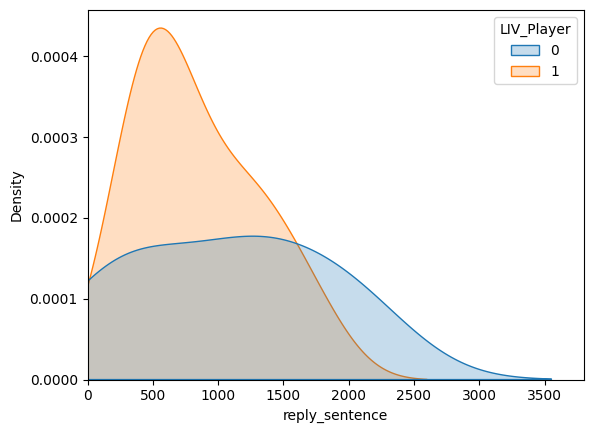

In [10]:
answer_players = freq_table(df,'player','reply_sentence',False)
answer_players['LIV_Player'] = answer_players['player'].isin(selected_players).astype(int)


#sns.histplot(data=answer_players.head(18), x='reply_sentence', bins=30, hue='LIV_Player', kde=True)
sns.kdeplot(data=answer_players.head(18), x='reply_sentence', hue='LIV_Player', fill=True)
plt.xlim(0, None)
# Show the plot
plt.show()

#### What is the proportion of player interviews in our dataset?

,player,reply_sentence,total,perc,accum,LIV_Player
103,rory mcilroy,2073,19352,0.11,0.11,0
109,scottie scheffler,1948,19352,0.10,0.21,0
53,jon rahm,1714,19352,0.09,0.30,1
54,jordan spieth,1371,19352,0.07,0.37,0
11,brooks koepka,1326,19352,0.07,0.44,1
31,dustin johnson,1280,19352,0.07,0.51,1


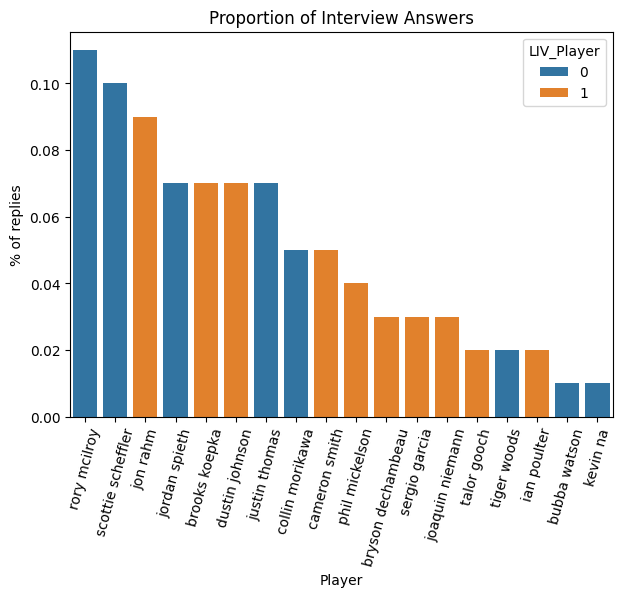

In [11]:
display(answer_players.head(6))


# Create a bar plot
plt.figure(figsize=(7, 5))
sns.barplot(data=answer_players.head(18), x='player', y='perc',hue='LIV_Player', palette=['#1f77b4', '#ff7f0e'])
plt.xticks(rotation=75)
plt.title('Proportion of Interview Answers')
plt.xlabel('Player')
plt.ylabel('% of replies')
plt.show()


#### Which players have been consistently giving interviews and press conferences?

# Players: 136   # Months:  42


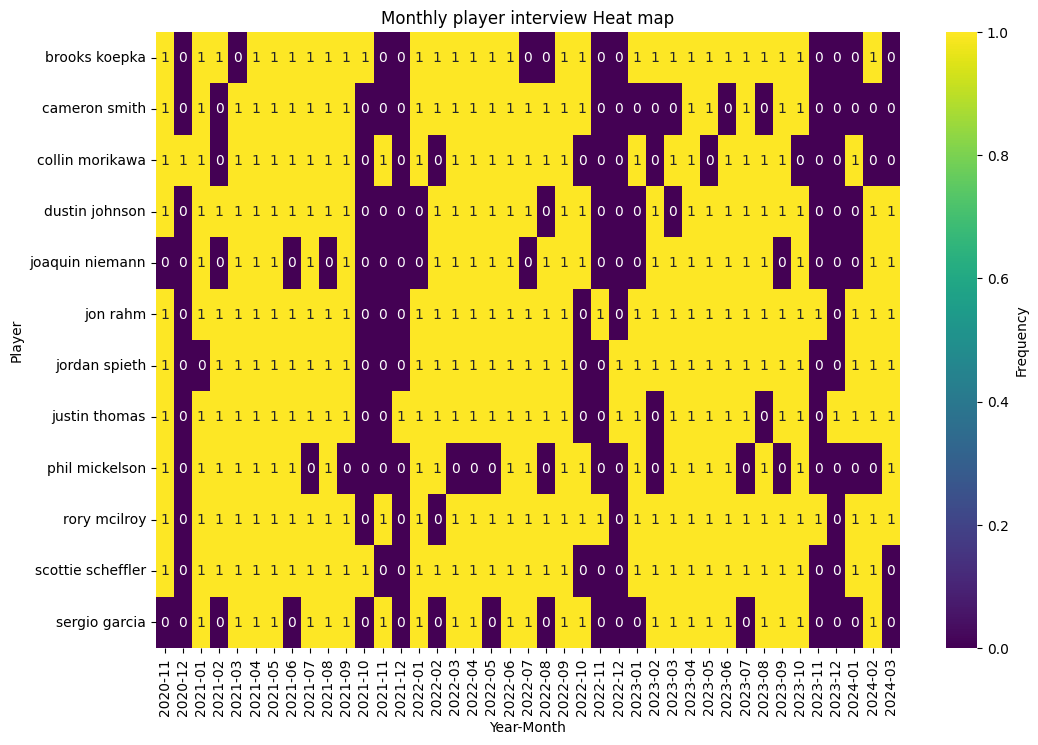

In [12]:
############ Creating a Support Table (Aggregated by player and year-month, Count of replies)

top_players = answer_players['player'].head(18)
player_month = df[df['player'].isin(top_players)].groupby(['player','year_month'])['reply_sentence'].count().reset_index()
player_month = player_month.sort_values(by=['player','year_month'],ascending=[True,True])


############ Creating a Frequency Matrix

def count_nonzero_columns(row):
    return (row != 0).sum()

# Creating a Frequency matrix: Players (Rows) year-month (Columns)
frq_table = pd.crosstab(index=df['player'].astype(str), columns=df['year_month'].astype(str), margins=False).round(2)

# Apply the function to each row and create a new column 'nonzero_count'
frq_table['nonzero_count'] = frq_table.apply(count_nonzero_columns, axis=1)
frq_table = frq_table.sort_values(by='nonzero_count',ascending=False)
print('# Players:',frq_table.shape[0],' ', '# Months: ',frq_table.shape[1])


############ Merge player-month interview count with our non-zero months counter.

frq_table_sub = frq_table[['nonzero_count']].reset_index()
frq_table_sub = frq_table_sub[['player','nonzero_count']]

#Merging
player_month = player_month.merge(frq_table_sub,how='left',on='player')
# Sorting + filtering >50% months
player_month = player_month.sort_values(by=['nonzero_count','player','year_month'],ascending=[False,False,True])
player_month_top = player_month[player_month['nonzero_count'] >= 22]


############ Plotting Heat Map
pivot_table = player_month_top.pivot_table(index='player', columns='year_month', values='reply_sentence', aggfunc='count', fill_value=0)

# Create a heatmap plot
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='g', cbar_kws={'label': 'Frequency'})

# Set plot labels and title
plt.xlabel('Year-Month')
plt.ylabel('Player')
plt.title('Monthly player interview Heat map')

# Show the plot
plt.show()

### Player Selection - Gave interviews in >50% of the analyzed months

- Reduced the size of dataset from 19352 to 14815 rows

In [13]:
analysis_list = player_month_top['player'].unique().tolist()

################ Create new Dataframe

df_pre = df[df['player'].isin(analysis_list)]

In [14]:
# How many belong to the PGA and to LIV ? 
Player_leagues = df_pre.groupby('LIV_Player')['player'].unique()
print('PGA: ',len(Player_leagues[0]))
print(Player_leagues[0])
print('LIV: ',len(Player_leagues[1]))
print(Player_leagues[1])

PGA:  5
['rory mcilroy' 'jordan spieth' 'justin thomas' 'scottie scheffler'
 'collin morikawa']
LIV:  7
['jon rahm' 'brooks koepka' 'sergio garcia' 'dustin johnson'
 'phil mickelson' 'joaquin niemann' 'cameron smith']


#### What is the word distribution per reply?

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_79044/560346463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['reply_length'] = [len(i.split()) for i in df_pre['reply_sentence']]


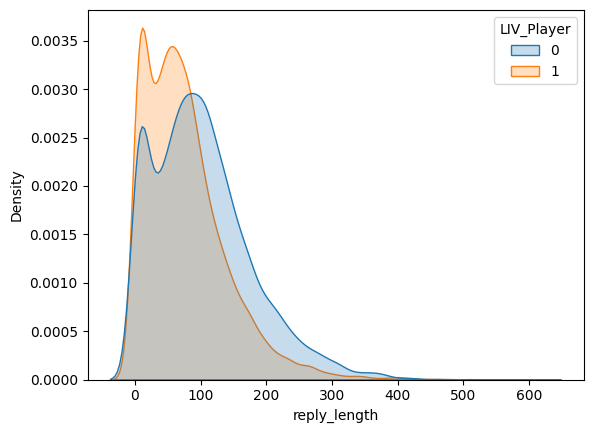

In [15]:
#Create column with the length of each reply
df_pre['reply_length'] = [len(i.split()) for i in df_pre['reply_sentence']]

sns.kdeplot(data=df_pre, x='reply_length', hue='LIV_Player', fill=True)
#plt.xlim(0, None)
# Show the plot
plt.show()

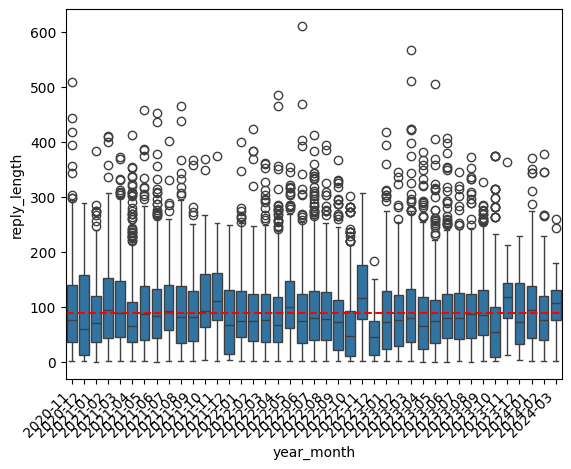

In [16]:
df_pre_ordered = df_pre.sort_values(by='year_month',ascending=True)

sns.boxplot(data=df_pre_ordered, x='year_month', y='reply_length', fill=True)
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_pre_ordered['reply_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean Reply Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

### Step 3 - Aggregate replies by player and year_month
- Reduced rows to 344 documents

In [17]:
# First Step Create the base table with Liv_player and reply_length aggregated
df_pre_month = df_pre.groupby(['player', 'year_month']).agg({'LIV_Player': 'max', 'reply_length': 'sum'}).reset_index()
#Concatenate separately replies and questions by month 
monthly_aggregated_reply = df_pre.groupby(['player', 'year_month'])['reply_sentence'].agg(lambda x: ' '.join(x)).reset_index(name='concatenated_interviews')
monthly_aggregated_quest = df_pre.groupby(['player', 'year_month'])['question'].agg(lambda x: ' '.join(x)).reset_index(name='concatenated_questions')

In [18]:
#Merge tables
df_month = df_pre_month.merge(monthly_aggregated_reply,how='left',on=['player','year_month'],suffixes=('sub','ex'))
df_month = df_month.merge(monthly_aggregated_quest,how='left',on=['player','year_month'],suffixes=('on','wh'))

#### What is the word distribution per reply after aggregating by player & year_month?

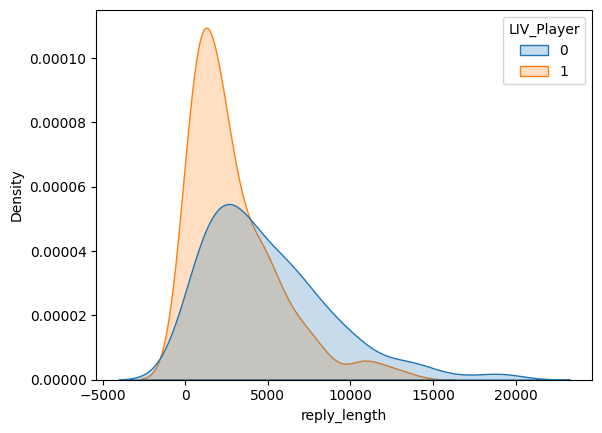

In [19]:
sns.kdeplot(data=df_month, x='reply_length', hue='LIV_Player', fill=True)
#plt.xlim(0, None)
# Show the plot
plt.show()

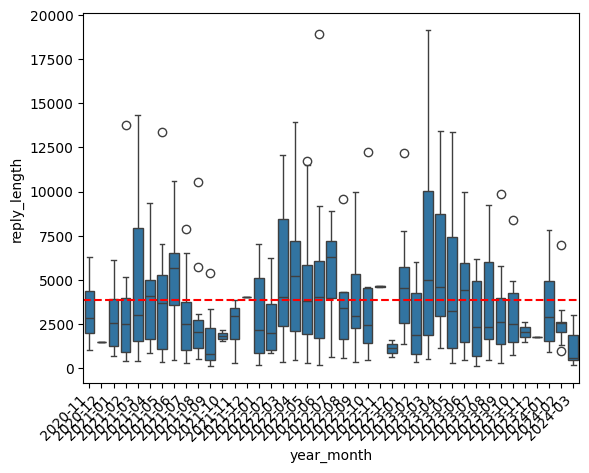

In [20]:
df_month_ordered = df_month.sort_values(by='year_month',ascending=True)

sns.boxplot(data=df_month_ordered, x='year_month', y='reply_length', fill=True)
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_month_ordered['reply_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean Reply Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

### Step 4 - Incorporate Target Variable ( 1: Player switch to LIV  ,    0: No movement )

In [21]:
# List of players and their corresponding specific dates
players_and_dates = {
    'sergio garcia': pd.Period('2022-06'),
    'dustin johnson': pd.Period('2022-06'),
    'phil mickelson': pd.Period('2022-06'),
    'ian poulter': pd.Period('2022-06'),
    'talor gooch': pd.Period('2022-06'),
    'cameron smith': pd.Period('2022-08'),
    'joaquin niemann': pd.Period('2022-09'),
    'bryson dechambeau': pd.Period('2022-06'),
    'brooks koepka': pd.Period('2022-06'),
    'jon rahm': pd.Period('2023-12'),
    # Add more players and dates as needed
}
df_month['LIV_CHANGE'] = df_month.apply(lambda row: 1 if (row['player'].lower() in players_and_dates and row['year_month'] == players_and_dates[row['player'].lower()]) else 0, axis=1)
df_month['year'] = df_month['year_month'].dt.year
df_month = df_month[['player','LIV_Player','year_month','year','reply_length','concatenated_interviews','concatenated_questions','LIV_CHANGE']]
df_month.head()

,player,LIV_Player,year_month,year,reply_length,concatenated_interviews,concatenated_questions,LIV_CHANGE
0,brooks koepka,1,2020-11,2020,2158,i mean i wouldn't call them steady they're pre...,MODERATOR MODERATOR MODERATOR MODERATOR MODERA...,0
1,brooks koepka,1,2021-01,2021,733,yeah it was nice spent a few weeks at home and...,MODERATOR MODERATOR MODERATOR can you give me ...,0
2,brooks koepka,1,2021-02,2021,2440,yeah i love this place this golf course is alw...,MODERATOR MODERATOR MODERATOR so you had i gue...,0
3,brooks koepka,1,2021-04,2021,1584,i missed the cut so it isn't very good is it p...,assess how the last two days went overall just...,0
4,brooks koepka,1,2021-05,2021,4700,just how bad i putted the last two days three ...,MODERATOR MODERATOR MODERATOR MODERATOR that b...,0


### Step 5 - Preprocessing

In [22]:
import os
import csv
from tqdm import tqdm # Tracking loading progress
tqdm.pandas()
# Preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords # Add MODERATOR TO THE STOPWORDS LIST
#!python -m spacy download en_core_web_sm
import spacy
import pickle
sp = spacy.load('en_core_web_sm')
#Regex
import re

#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#Text Mining & Dimensionality Reduction
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation

In [23]:
## Preprocesing both interviews and questions
df_month['interv_prepr'] = txtprocess_tok(df_month,'concatenated_interviews',2)
df_month['quest_prepr'] = txtprocess_tok(df_month,'concatenated_questions',2)

df_month = df_month[['player','LIV_Player','year_month','year','reply_length','interv_prepr','quest_prepr','concatenated_interviews','concatenated_questions','LIV_CHANGE']]
df_month.shape

100%|██████████| 344/344 [00:42<00:00,  8.03it/s]


(344, 10)

### Step 6 - Normalization 

In [24]:
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.05, max_df=0.4, stop_words='english')
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv = TfidfVectorizer(ngram_range = (1,2), norm='l2', lowercase=True, min_df=0.1, max_df=0.6, stop_words='english')
cv.fit(df_month['interv_prepr'])

vectorized_text=cv.transform(df_month['interv_prepr'])
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)
print(cv.get_feature_names_out())

# Same transformation for questions
vectorized_title=cv.transform(df_month['quest_prepr'])
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)

document term matrix has size (344, 1642)
['ability' 'able come' 'able hit' ... 'yesterday today' 'young'
 'young guy']
document term matrix has size (344, 1642)


### Step 7 - Dimensionality Reduction

U (document-topic matrix): Each row in U represents a document (in our case, a sentence) in the new topic space defined by SVD. The values indicate how strongly each document is associated with a topic.

Sigma (singular values): The values in Σ represent the strength or importance of each topic uncovered by SVD. Higher values mean the topic is more significant in capturing the variance (or information) in the dataset.

VT (topic-term matrix): Each row in V^T represents a topic, and the values indicate how each term is associated with that topic. This helps in understanding what each topic is about.

In [25]:
# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(vectorized_text)
Sigma = svd.singular_values_
VT = svd.components_

In [26]:
terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('sort', 0.15685823072376562), ('open', 0.0956999436773018), ('major', 0.09367779735785327), ('match', 0.08821383458568245), ('remember', 0.08118300683229066)]
Topic 2:  [('sort', 0.8993323916232246), ('certainly', 0.1126152171403353), ('dubai', 0.07986329653355438), ('yeah look', 0.04981482016155139), ('open', 0.0397122186404262)]
Topic 3:  [('ryder', 0.2607799961944626), ('ryder cup', 0.2590257498183787), ('cup', 0.255320798614069), ('match', 0.19885090207139874), ('liv', 0.1743756102257751)]
Topic 4:  [('match', 0.21155901966858034), ('yeah obviously', 0.16304943026225438), ('solid', 0.1583770845803349), ('excited', 0.1433858608816516), ('nicely', 0.13864113236825298)]
Topic 5:  [('liv', 0.34392771686217133), ('game golf', 0.1342694536812669), ('support', 0.11822007853048852), ('compete', 0.11706083960207896), ('pga', 0.10917178246139911)]
Topic 6:  [('match', 0.39799952297217545), ('match play', 0.1567887665911619), ('liv', 0.13262961336677523), ('certainly', 0.111190384

#### Same for Interview questions

In [27]:
svd1 = TruncatedSVD(n_components=10)
svd1.fit(vectorized_text)
U1 = svd1.transform(vectorized_title)
Sigma1 = svd1.singular_values_
VT1 = svd1.components_

In [136]:
terms = cv.get_feature_names_out()
for i, comp in enumerate(VT1):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('sort', 0.15685823078621036), ('open', 0.09569994351469387), ('major', 0.0936777975101002), ('match', 0.08821383384539117), ('remember', 0.0811830071491844)]
Topic 2:  [('sort', 0.8993360728266798), ('certainly', 0.11260657914188191), ('dubai', 0.0798565386288245), ('yeah look', 0.04981467084715237), ('open', 0.039725375468140874)]
Topic 3:  [('ryder', 0.2608152899507817), ('ryder cup', 0.25906050400158037), ('cup', 0.2553084832322517), ('match', 0.19900603247932672), ('liv', 0.17424523521793386)]
Topic 4:  [('match', 0.21143616343792715), ('yeah obviously', 0.16272369069593243), ('solid', 0.1572993099783532), ('excited', 0.14334844993870044), ('nicely', 0.14066585489120148)]
Topic 5:  [('liv', 0.3444111768299333), ('game golf', 0.13387386228611617), ('support', 0.11816347635100244), ('compete', 0.11714929328553307), ('pga', 0.10958117447862557)]
Topic 6:  [('match', 0.3945956205851368), ('match play', 0.15436422933450655), ('liv', 0.1308436615364172), ('certainly', 0.11638

### Experiment for Labeling original dataset

In [35]:
df_test = df_pre.copy()
## Preprocesing both interviews and questions
df_test['interv_pre'] = txtprocess_tok(df_test,'reply_sentence',2)
df_test['quest_pre'] = txtprocess_tok(df_test,'question',2)

100%|██████████| 14815/14815 [01:01<00:00, 239.10it/s]


In [39]:

vectorized_text2=cv.transform(df_test['interv_pre'])
vectorized_text2=vectorized_text2.toarray()
#vectorized_text2 = vectorized_text2.todense()

#SVD
U_original = svd.transform(vectorized_text2)

#Applying Labels
df_test['topic_label'] = np.argmax(U_original, axis=1)

In [47]:
for i in df_test[df_test['topic_label'] == 5]['interv_pre'][20:50]:
    print(i)

finish yesterday plenty time rest get ready morning pretty much say tough week sometimes get wrong side thing like brooks go decide go play terrible kind start party get bad start thing spiral control emotional round care lot tournament one favourite tournament year team event tough beat like guy say feel like close group guy time feel like let guy put morning get point far play three match feel like good chance get point friday go saturday morning able get much momentum go pretty tough go first today want could get point board team want come fight doubt put another good fight another halve tough really know say want win match today guy really long answer short one want win match teammate pretty much
drink ton livpur hydration packet think overdo yeah try force try force food get anything continue energy hot hot lot go sit say kind heat come scottish british certainly little bit different
yeah guess like left arm elbow feel anything get try lock left side may little bent good traction 